In [2]:
import os 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from make_models import get_MRI_VAE_3D,get_MRI_CVAE_3D
from tqdm import tqdm 

In [3]:
import matplotlib as mpl
from IPython import display
import time
from matplotlib import colors
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
from sklearn.decomposition import PCA
from rsa_funcs import fit_rsa,make_RDM,get_triu

In [20]:
import tensorflow as tf

In [4]:
data_arr = np.load('../../BC-sim/synth-data-01/sim-brain-array-1.npz')
print(list(data_arr.keys()))
data = data_arr['data']
control = data_arr['controls']
patients = data_arr['patients']
n = data.shape[0]
print(data.shape)
data[patients,:,:,:].shape
data[patients].shape

['data', 'controls', 'patients']
(1000, 64, 64, 64)


(500, 64, 64, 64)

In [4]:
# data loader
class cvae_data_loader_adhd():
    ''' this is the info'''
    def __init__(self,data,patients,batch_size=32):
    
        self.data = data
        
        self.n = data.shape[0]
        self.epoch = -1
        self.batch_size = batch_size
        
        self.new_epoch()
        self.n_batches = int(np.floor(min((len(self.adhd_idxs),len(self.td_idxs)))/self.batch_size)) # How many batches fit, take the min(n_ADHD,n_TD) then divide by batch size
        
    def new_epoch(self):

        self.adhd_idxs = np.nonzero(patients==True)[0] # idxs of patients
        self.td_idxs = np.nonzero(patients==False)[0] # idxs of TDs
        
        self.adhd_idxs = np.random.permutation(self.adhd_idxs)
        self.td_idxs = np.random.permutation(self.td_idxs)
        
        self.epoch += 1
        self.b = 0
        
        
    def get_batch(self):
        self.b += 1
        
        if self.b==self.n_batches:
            self.new_epoch()
        
        self.batch_adhd_idx = self.adhd_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        self.batch_td_idx = self.td_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        # go through the patients and controls in batch size chunks
        # batch_indeces = all_indices[batch number * batch size : batch number * batch size + batch size]
        
        self.batch_adhd = self.data[self.batch_adhd_idx,:,:,:]
        self.batch_td = self.data[self.batch_td_idx,:,:,:]
        
        _,counts = np.unique(np.hstack((self.batch_adhd_idx,self.batch_td_idx)),return_counts=True)
        assert all(counts==1),'not all unique, somethings wrong'
        
        return self.batch_adhd,self.batch_td

In [5]:
data_loader = cvae_data_loader_adhd(data,patients)

In [6]:
tf.__version__

'2.3.1'

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

In [25]:
# Make sure you have GPU enabled
# Test 100 epochs
# n_epochs = 100
# n_batches = data_loader.n_batches # dataloader calcs how many batches
# loss = []
# for epoch in tqdm(range(n_epochs)):
#     for batch in range(n_batches):
#         if np.mod(epoch, 10) == 0:
#             cvae.save_weights('/mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_100_epochs') 
#         adhd_batch, td_batch = data_loader.get_batch()
#         l = cvae.train_on_batch([adhd_batch,td_batch]) # [TG,BG]
#         loss.append(l)
#         if np.mod(epoch, 10) == 0:
#             np.save('sim_loss_100_epochs', np.array(loss))

100%|██████████| 100/100 [15:30<00:00,  9.31s/it]


In [5]:
cvae.load_weights('/mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_100_epochs')

In [ ]:
def get_reconstruction(data_in,adhd = True):

    z = z_encoder.predict(data_in)[0] # mu,std,sample
    s = s_encoder.predict(data_in)[0]

    if adhd==True:
        l = np.hstack((z,s))
    else:
        l = np.hstack((z,np.zeros(s.shape)))

    recon = cvae_decoder(l)[:,:,:,:,0]
    return recon

In [ ]:
data_patients = data[patients,:,:,:]
data_controls = data[control,:,:,:]

In [ ]:
%%time
recon_patients = get_reconstruction(data_patients,adhd = True)
recon_controls = get_reconstruction(data_controls,adhd = False)


In [ ]:
recon_patients.shape

In [ ]:
np.array(recon_patients).max()

In [ ]:
np.array(recon_patients).min()

In [ ]:
np.array(data_patients).max()


In [ ]:
np.array(data_patients).min()


## Reconstruction: Subject 0

In [ ]:
s = 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [9]:
# Make sure you have GPU enabled
# 5000 epochs
# n_epochs = 5000
# n_batches = data_loader.n_batches # dataloader calcs how many batches
# loss = []
# for epoch in tqdm(range(n_epochs)):
#     for batch in range(n_batches):
#         if np.mod(epoch, 10) == 0:
#             cvae.save_weights('/mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_5k_epochs') 
#         adhd_batch, td_batch = data_loader.get_batch()
#         l = cvae.train_on_batch([adhd_batch,td_batch]) # [TG,BG]
#         loss.append(l)
#         if np.mod(epoch, 10) == 0:
#             np.save('sim_loss_5k_epochs', np.array(loss))

100%|██████████| 5000/5000 [13:10:05<00:00,  9.48s/it]  


In [ ]:
if train_cvae:
    
    cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)
    loss = []

In [ ]:
TD_subs = data[controls,:,:,:] # Data of Typically Developing participants 
DX_subs = data[patients,:,:,:] # Data of ADHD participants


nbatches = 50
if train_cvae:
    for i in tqdm(range(1,nbatches)):
        
        DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
        TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];
        
        hist = cvae.train_on_batch([DX_batch,TD_batch]);
        loss.append(hist);
        
        mse = ((np.array([DX_batch,TD_batch])-np.array(cvae.predict([DX_batch,TD_batch]))[:,:,:,:,:,0])**2).mean()

        assert not np.isnan(hist),'loss is NaN - somethings wrong'

        im,im1,ss = cvae_query(data, s_encoder, z_encoder, cvae_decoder); 


        if np.mod(i,5)==0: # Plot training progress
            plot_trainProgress(loss,im,im1);
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0)
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1)

        if np.mod(i,101)==0: # Save every 100 batches
            cvae.save_weights('/mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_5k_epochs')
            
        if mse < .005:
            break

In [9]:
#cvae.load_weights('/mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_5k_epochs')

In [10]:
def get_reconstruction(data_in,adhd = True):

    z = z_encoder.predict(data_in)[0] # mu,std,sample
    s = s_encoder.predict(data_in)[0]

    if adhd==True:
        l = np.hstack((z,s))
    else:
        l = np.hstack((z,np.zeros(s.shape)))

    recon = cvae_decoder(l)[:,:,:,:,0]
    return recon

In [11]:
data_patients = data[patients,:,:,:]
data_controls = data[control,:,:,:]

In [12]:
%%time
recon_patients = get_reconstruction(data_patients,adhd = True)
recon_controls = get_reconstruction(data_controls,adhd = False)


CPU times: user 2min 35s, sys: 14.5 s, total: 2min 49s
Wall time: 2min 50s


In [13]:
recon_patients.shape

TensorShape([500, 64, 64, 64])

In [14]:
np.array(recon_patients).max()

0.9982625

In [15]:
np.array(recon_patients).min()

0.0

In [16]:
np.array(data_patients).max()


1.0

In [17]:
np.array(data_patients).min()


0.0

## Reconstruction: Subject 0

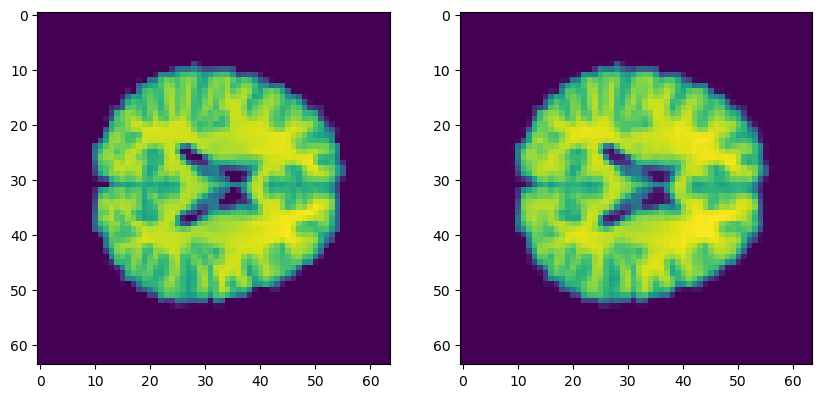

In [18]:
s = 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [21]:
data = data_patients[0,:,:,:]
predict = recon_patients[0,:,:,:]
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
mse(data, predict).numpy()

9.661174e-05

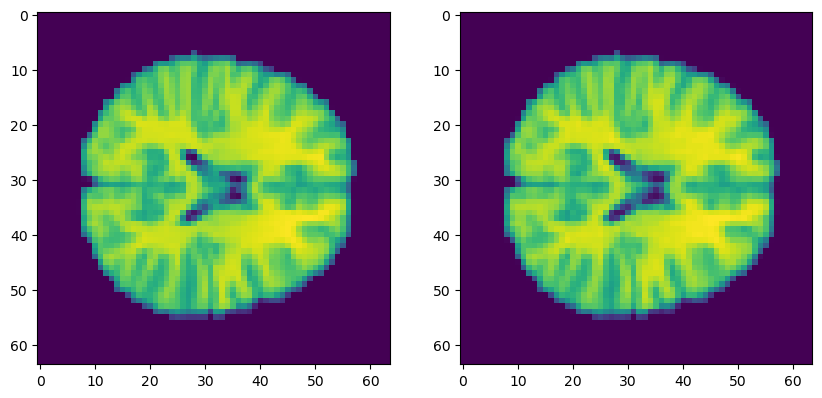

In [22]:
s = 1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

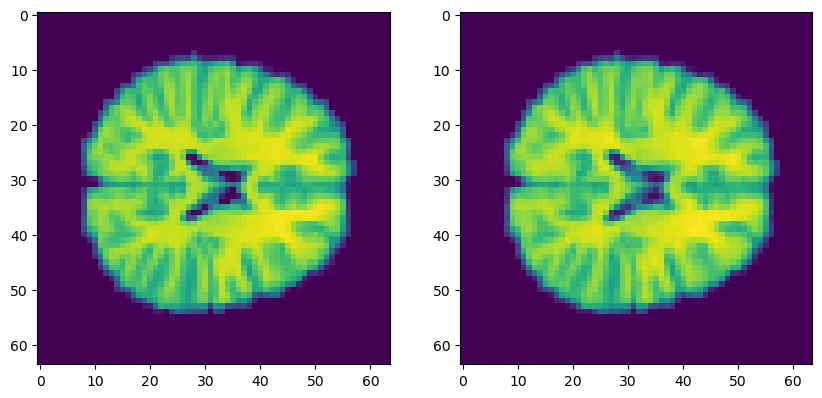

In [23]:
s = 100
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

## MSE loop

In [24]:
mse_list = []
for s in range(0,500):
    data = np.array(data_patients[s,:,:,:])
    predict = np.array(recon_patients[s,:,:,:])
    mse = ((data-predict)**2).mean()
    mse_list.append(mse)

mse_arr = np.array(mse_list)

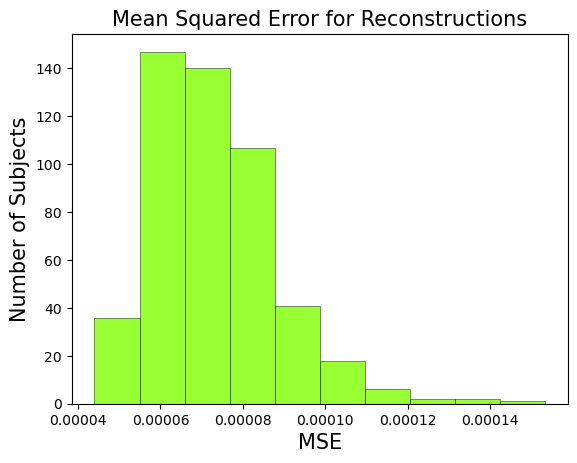

In [25]:
plt.hist(mse_arr, alpha = 0.8, color='chartreuse', edgecolor = 'black', linewidth=0.4 )
plt.title('Mean Squared Error for Reconstructions', fontsize = 15)
plt.xlabel('MSE', fontsize = 15)
plt.ylabel('Number of Subjects', fontsize = 15)
plt.show()

In [26]:
np.argmin(mse_arr) #

435

## Reconstruction with Lowest MSE (Best)

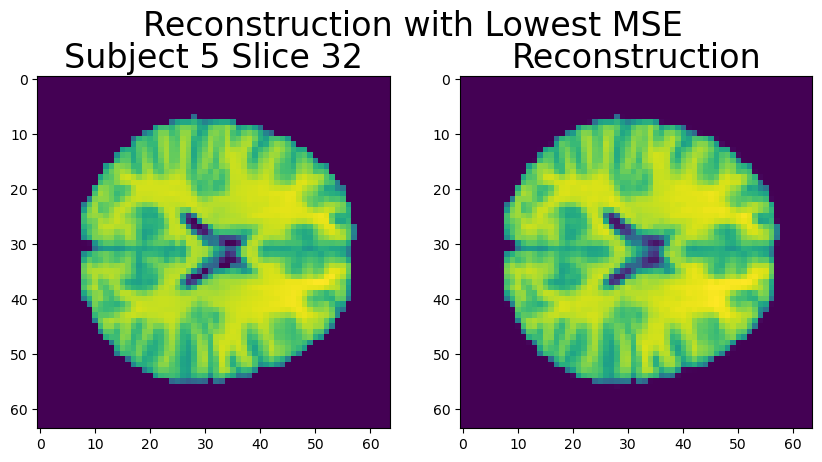

In [27]:
s = 435
figure = plt.figure(figsize=(10,5))
figure.suptitle('Reconstruction with Lowest MSE', fontsize=24)
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.title('Subject 5 Slice 32', fontsize = 24)
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.title('Reconstruction', fontsize = 24)
plt.show()

In [28]:
np.argmax(mse_arr) #

356

## Reconstruction with Highest MSE

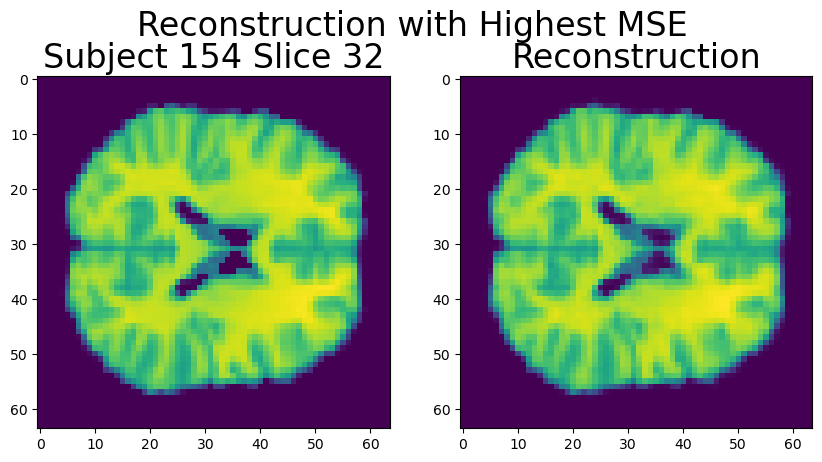

In [30]:
s = 356
figure2 = plt.figure(figsize=(10,5))
figure2.suptitle('Reconstruction with Highest MSE', fontsize=24)
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.title('Subject 154 Slice 32', fontsize = 24)
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.title('Reconstruction', fontsize = 24)
plt.show()

In [32]:
df = pd.read_csv('../../BC-sim/synth-data-01/sim_all_def.csv')

In [33]:
ADHDdf = df[df['DX'] != 0]
TDdf = df[df['DX'] == 0]

In [34]:
ADHDdf

,Unnamed: 0,Index,Sub,Sphere 1,Sphere 2,DX,S Deformation,Z Deformation
0,0,0,0,12.834489,10.035014,1,-2.799475,-4.043705
1,1,1,1,11.011581,11.316208,1,0.304627,-3.733940
2,2,2,2,12.606499,14.643771,1,2.037272,-4.385604
3,3,3,3,10.869074,13.482636,1,2.613562,-4.925275
4,4,4,4,6.159082,6.337349,1,0.178267,1.429249
...,...,...,...,...,...,...,...,...
495,495,495,495,7.543617,9.531810,1,1.988193,1.969164
496,496,496,496,12.901628,10.921605,1,-1.980023,-1.618177
497,497,497,497,5.062251,3.099718,1,-1.962533,-4.174104
498,498,498,498,14.173622,13.385439,1,-0.788183,4.945449


In [44]:
symptom_vector = ADHDdf['S Deformation'].values
symptom_vector

array([-2.79947527,  0.30462664,  2.03727205,  2.61356233,  0.17826748,
        0.53419311, -1.84472201,  1.88587619, -1.83464177,  1.35466179,
        1.41844268,  1.1432855 ,  0.51621531,  1.86163145, -0.49363845,
       -1.16619127, -2.94770216,  0.31849785, -0.39681439,  1.93356615,
        2.19137355,  2.47357005,  0.29687882,  1.27066434,  2.2811094 ,
       -1.81082647,  1.85152599, -1.80656489,  1.80041686, -1.144914  ,
        0.69133178, -0.95208009,  0.62800258, -0.6267277 , -1.15082105,
       -2.93080445, -1.34884795, -2.4554004 , -0.63545854,  0.17931633,
       -1.74709229,  0.83689515,  1.61844281, -1.04462509, -1.64994255,
       -1.3633386 , -2.24991411, -0.51175007,  1.30366083, -0.96027256,
        1.03042294, -1.04385548, -1.7209793 , -0.56308292,  2.2846093 ,
        1.49202453,  0.63547176, -0.60979895, -2.63442756, -1.29527528,
        2.86975519, -0.57091531, -1.81801214,  1.51082597,  1.56599708,
        2.76505613,  2.01808388,  2.44681336, -0.26802092, -0.81

In [45]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
symptom = np.array(symptom_vector)

In [46]:
s_patients_rdm = make_RDM(s_patients)
z_patients_rdm = make_RDM(z_patients)
symptom_rdm = make_RDM(symptom)

In [47]:
symptom_rdm.shape

(500, 500)

In [48]:
z_patients_rdm.shape

(500, 500)

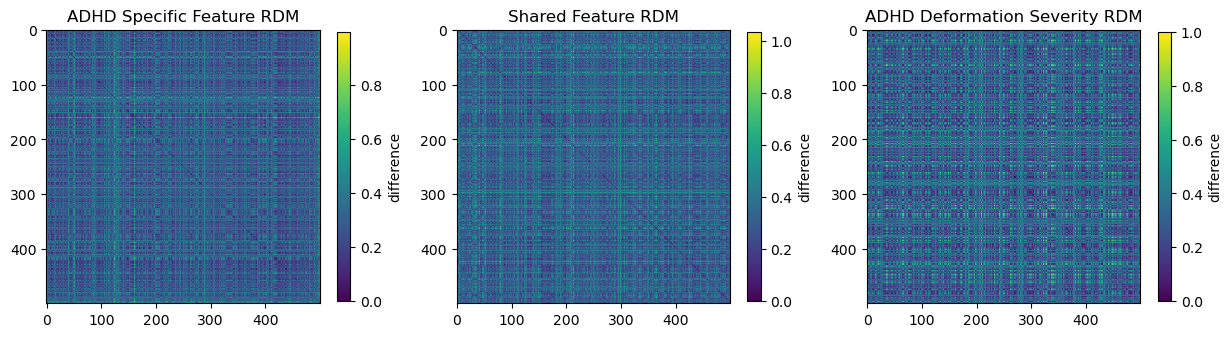

In [49]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm)
plt.title('ADHD Specific Feature RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm)
plt.title('Shared Feature RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,3,3)
plt.imshow(symptom_rdm)
plt.title('ADHD Deformation Severity RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.show()

## RSA: S Deformation

In [50]:
s_symptom_rsa = fit_rsa(s_patients_rdm, symptom_rdm)
s_symptom_rsa

0.00832276577454684

In [51]:
z_symptom_rsa = fit_rsa(z_patients_rdm, symptom_rdm)
z_symptom_rsa

-0.0026797113246687246